[[1339  246    0]
 [ 117 5783    0]
 [   0    0 2435]]
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      1585
         1.0       0.96      0.98      0.97      5900
         2.0       1.00      1.00      1.00      2435

    accuracy                           0.96      9920
   macro avg       0.96      0.94      0.95      9920
weighted avg       0.96      0.96      0.96      9920



<Figure size 1600x1600 with 0 Axes>

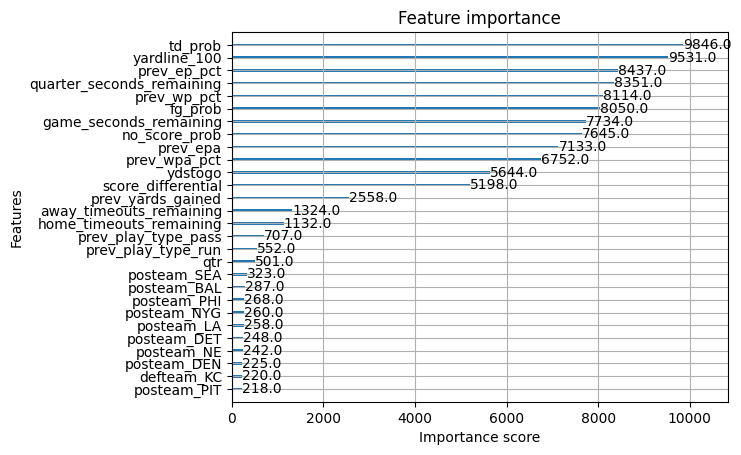

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from xgboost import plot_importance

warnings.filterwarnings("ignore")

data = ["NFL_PBP_DATA_2024.csv", "NFL_PBP_DATA_2023.csv", "NFL_PBP_DATA_2022.csv", "NFL_PBP_DATA_2021.csv", "NFL_PBP_DATA_2019.csv", 
        "NFL_PBP_DATA_2018.csv", "NFL_PBP_DATA_2017.csv", "NFL_PBP_DATA_2016.csv", "NFL_PBP_DATA_2015.csv", "NFL_PBP_DATA_2014.csv"]

df = [pd.read_csv(f"DATA/{file}") for file in data]
df = pd.concat(df, ignore_index=True)

df = df[df["play_type"].notna()]

# *Shift previous play stats*
df['prev_yards_gained'] = df['yards_gained'].shift(1)
df['prev_play_type'] = df['play_type'].shift(1)
df['prev_epa'] = df['epa'].shift(1)
df['prev_success'] = df['success'].shift(1)
df['prev_wpa_pct'] = df['wpa'].shift(1)
df['prev_ep_pct'] = df['ep'].shift(1)
df['prev_wp_pct'] = df['wp'].shift(1)

# *Filter data to only include 4th Down situations*
df = df[df["down"] == 4].copy()

df['decision'] = df['play_type'].map({
    'pass': 0,
    'run': 0,
    'punt': 1,
    'field_goal': 2
})

df = df[df['decision'].notna()]

# *List features to include in the model for better predictions*
features = ["posteam", "defteam", "yardline_100", "quarter_seconds_remaining", "game_seconds_remaining", "qtr", "ydstogo", "prev_yards_gained", 
            "prev_play_type", "prev_epa", "prev_success", "home_timeouts_remaining", "away_timeouts_remaining", "prev_ep_pct", "score_differential", 
            "prev_wp_pct", "prev_wpa_pct", "no_score_prob", "fg_prob", "td_prob"]

# *Create the model
# One-hot encode categorical features
X = pd.get_dummies(df[features])
y = df['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(16,16))
plot_importance(model, max_num_features=28)
plt.show()

In [2]:
# Example situation: 4th & 2 from opponent's 45, 3 minutes left in 4th quarter, down by 3
sample_input = {
    'posteam': 'PHI',
    'defteam': 'KC',
    'yardline_100': 50,
    'quarter_seconds_remaining': 119,
    'game_seconds_remaining': 119,
    'qtr': 4,
    'ydstogo': 6,
    'goal_to_go': 0,
    'prev_yards_gained': -1,
    'prev_play_type': 'run',
    'home_timeouts_remaining': 1,
    'away_timeouts_remaining': 0,
    'prev_ep_pct': 0.92,
    'prev_epa': -0.91,
    'score_differential': 26, 
    'prev_wp_pct': 0.999, 
    'prev_wpa_pct': -0.00001,
    'no_score_prob': 0.72, 
    'fg_prob': 0.04, 
    'td_prob': 0.08
}

import pandas as pd

# Turn into DataFrame
sample_df = pd.DataFrame([sample_input])

# One-hot encode (to match training)
sample_encoded = pd.get_dummies(sample_df)

# Align columns to training data
sample_encoded = sample_encoded.reindex(columns=X.columns, fill_value=0)

prediction = model.predict(sample_encoded)
probabilities = model.predict_proba(sample_encoded)

print(f"MODEL DECISION: {prediction[0]}")
print("PROBABILITIES: (GO-FOR-IT, PUNT-IT, FIELD-GOAL):", probabilities[0])

MODEL DECISION: 0
PROBABILITIES: (GO-FOR-IT, PUNT-IT, FIELD-GOAL): [7.5566530e-01 2.4430659e-01 2.8140099e-05]
